In [36]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
from math import sqrt
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import time
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [37]:
# Load testing dataset(Daily data)
def read_daily_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,sep = '\t',parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[features]
    return Lake_HydMet

In [38]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [39]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [40]:
# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [41]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [42]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [43]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [44]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [45]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [46]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[df['Date']<test_time[0]]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        rmse = sqrt(mean_squared_error(y_test, yhat))
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    model = fit_lstm(X,y_scaled,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                     hyperparameters['n_neuros'],hyperparameters['dropout'],
                     hyperparameters['verbose'],hyperparameters['loss_function'])
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [47]:
## Load training dataset
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
    
os.chdir('Trainning data')
print('Load training data (containing nutrient observations)')
lakename = input('Lake name in short:')
winter = input('Winter data or not? (Y/N)')
if winter =='Y':
    all_df = pd.read_csv(lakename+'_Observation_df.csv',sep = '\t',parse_dates = ['Date'])
else:
    all_df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])

Load training data (containing nutrient observations)
Lake name in short:Ekoln
Winter data or not? (Y/N)N


In [48]:
# Create the daily df with Nan in nutrients columns'
print(all_df.info())
n_Nut = int(input('Number of nutrients: (including Chl)'))
Nut_f = ['Date']
for i in range(n_Nut):
    f = input('Nutrients: ')
    Nut_f.append(f)
print(Nut_f)
Nut = all_df[Nut_f]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             297 non-null    datetime64[ns]
 1   thermD           297 non-null    float64       
 2   MLD              297 non-null    float64       
 3   swr              297 non-null    float64       
 4   U                297 non-null    float64       
 5   AirP             297 non-null    float64       
 6   AirT             297 non-null    float64       
 7   CC               297 non-null    float64       
 8   Prec             297 non-null    float64       
 9   RelHum           297 non-null    float64       
 10  Inflow           297 non-null    float64       
 11  W                297 non-null    float64       
 12  delT             297 non-null    float64       
 13  Ice_d            297 non-null    int64         
 14  day_from_iceoff  297 non-null    float64  

In [49]:
n_feature = int(input('Number of features used for basic training: '))
features = ['Date']
for i in range(n_feature):
    f = input('Feature:')
    features.append(f)
print(features)

Number of features used for basic training: 14
Feature:thermD
Feature:W
Feature:MLD
Feature:CC
Feature:U
Feature:Prec
Feature:Inflow
Feature:Ice_d
Feature:day_from_iceoff
Feature:delT
Feature:AirP
Feature:AirT
Feature:swr
Feature:RelHum
['Date', 'thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum']


In [50]:
# date to seperate training and test sets
YY=all_df['Date'].apply(lambda d:d.year).unique()
print(YY)
test_time = [pd.Timestamp(int(input('test starts in year:')),1,1),pd.Timestamp(int(input('test ends in year:')),1,1)]

[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019]
test starts in year:2014
test ends in year:2020


In [51]:
# Read daily observation data
if winter =='Y':
    file = lakename+'_Daily_Observation_df.csv'
else:
    file = lakename+'_Daily_Observation_df_nowinter.csv'
Daily_df = read_daily_df(test_time,features,file) 

In [58]:
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':100,'n_neuros':100,'dropout':0,'time_steps':7,
                   'n_out':1,'verbose':0,
                  'loss_function':'mae'}

In [53]:
# Change to the LSTM folder
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM')

Nutrient: NOX
(7020, 8, 14) (7020,) (1546, 8, 14) (1546,)
number of input timesteps: 8
number of features: 14
number of samples: 144
Test RMSE: 346.70
Test R2: 0.36
Training dataset RMSE 235.20 (+/- 26.49)
Training dataset R2 0.52 (+/- 0.09)
Model takes 2 min to run


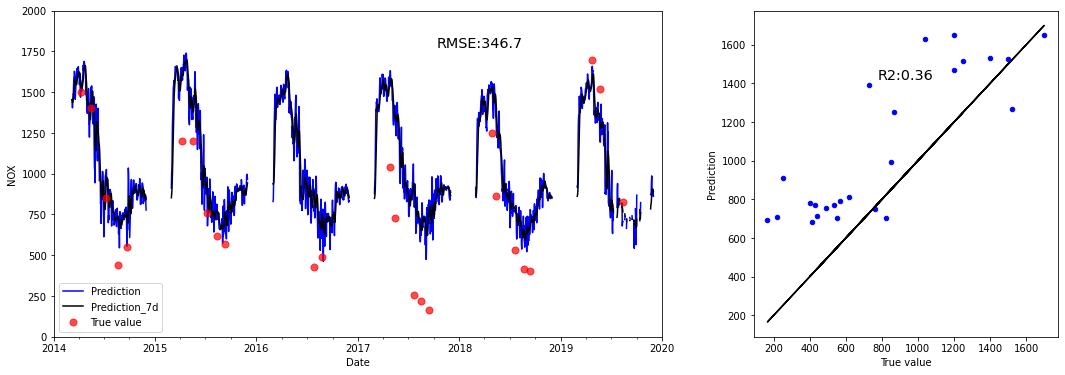

In [59]:
# predict nutreint 1
nutrient = input('Nutrient: ')
# If add the features from process-based model, add features 'MLD','W','thermD'
features.pop(0) # Remove 'Date'
features.append(nutrient)
Scaler = MinMaxScaler()
Nut_memory = Daily_df.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                            how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [60]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8568,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890
8569,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305
8570,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150
8571,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428


Nutrient: O2
['thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum', 'NOX']
Delete features? (Y/N)N
Add features? (Y/N)N
(7025, 8, 15) (7025,) (1546, 8, 15) (1546,)
number of input timesteps: 8
number of features: 15
number of samples: 149
Test RMSE: 1.11
Test R2: 0.57
Training dataset RMSE 1.05 (+/- 0.20)
Training dataset R2 0.52 (+/- 0.09)
Model takes 2 min to run


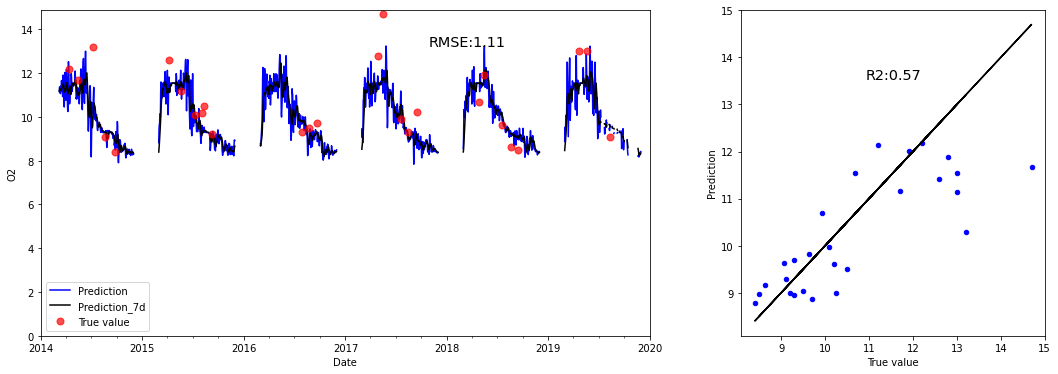

In [61]:
# predict nutreint 2
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates()
                              ,how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [62]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX,O2
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442,11.519440
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442,11.519440
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442,11.519440
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442,11.519440
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442,11.519440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8573,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890,8.367984
8574,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305,8.339104
8575,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150,8.338394
8576,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428,8.376356


Nutrient: PO4-P
['thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum', 'NOX', 'O2']
Delete features? (Y/N)N
Add features? (Y/N)N
(7033, 8, 16) (7033,) (1546, 8, 16) (1546,)
number of input timesteps: 8
number of features: 16
number of samples: 157
Test RMSE: 11.02
Test R2: -0.12
Training dataset RMSE 7.89 (+/- 0.73)
Training dataset R2 0.53 (+/- 0.09)
Model takes 2 min to run


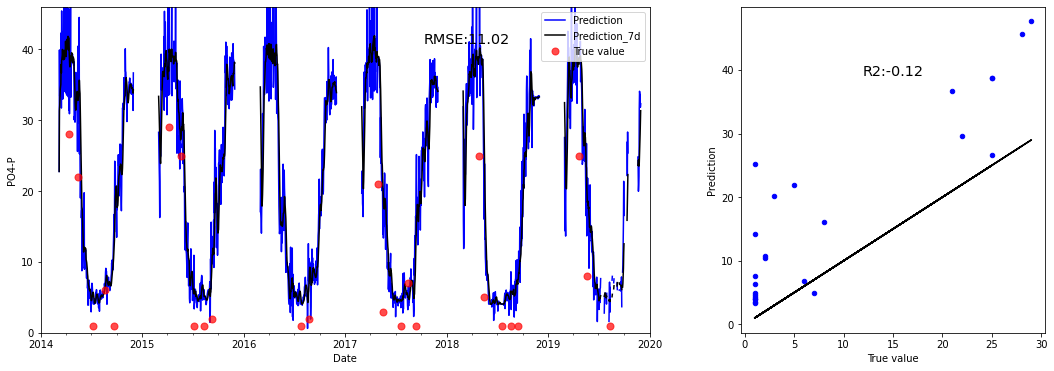

In [63]:
# predict nutreint 3
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [64]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX,O2,PO4-P
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442,11.519440,28.403126
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442,11.519440,28.403126
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442,11.519440,28.403126
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442,11.519440,28.403126
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442,11.519440,28.403126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8581,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890,8.367984,34.064419
8582,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305,8.339104,33.704712
8583,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150,8.338394,33.564476
8584,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428,8.376356,31.807388


Nutrient: Tot-P
['thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum', 'NOX', 'O2', 'PO4-P']
Delete features? (Y/N)N
Add features? (Y/N)N
(7049, 8, 17) (7049,) (1546, 8, 17) (1546,)
number of input timesteps: 8
number of features: 17
number of samples: 173
Test RMSE: 9.91
Test R2: 0.45
Training dataset RMSE 11.88 (+/- 2.38)
Training dataset R2 0.31 (+/- 0.21)
Model takes 2 min to run


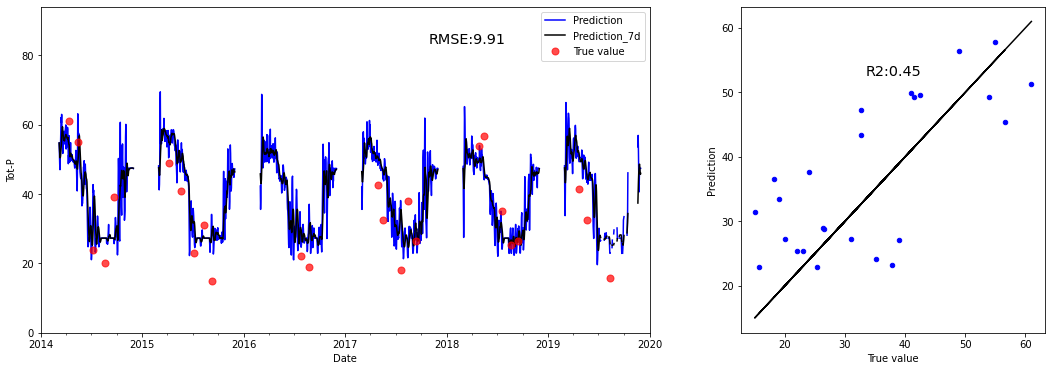

In [65]:
# predict nutreint 4
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [66]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX,O2,PO4-P,Tot-P
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442,11.519440,28.403126,50.865154
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442,11.519440,28.403126,50.865154
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442,11.519440,28.403126,50.865154
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442,11.519440,28.403126,50.865154
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442,11.519440,28.403126,50.865154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8597,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890,8.367984,34.064419,47.473713
8598,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305,8.339104,33.704712,47.480621
8599,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150,8.338394,33.564476,47.480827
8600,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428,8.376356,31.807388,47.442314


Nutrient: NH4-N
['thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum', 'NOX', 'O2', 'PO4-P', 'Tot-P']
Delete features? (Y/N)N
Add features? (Y/N)N
(7081, 8, 18) (7081,) (1546, 8, 18) (1546,)
number of input timesteps: 8
number of features: 18
number of samples: 205
Test RMSE: 14.48
Test R2: 0.10
Training dataset RMSE 11.37 (+/- 2.52)
Training dataset R2 -0.06 (+/- 0.11)
Model takes 3 min to run


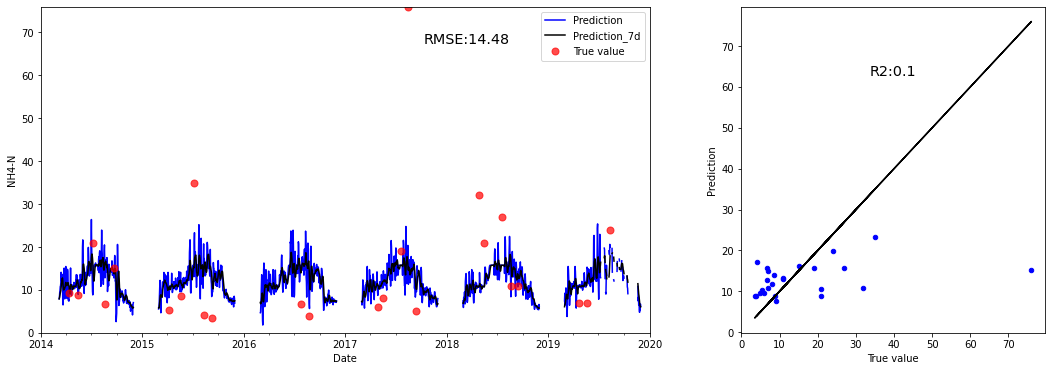

In [67]:
# predict nutreint 5
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [68]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX,O2,PO4-P,Tot-P,NH4-N
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442,11.519440,28.403126,50.865154,10.586343
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442,11.519440,28.403126,50.865154,10.586343
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442,11.519440,28.403126,50.865154,10.586343
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442,11.519440,28.403126,50.865154,10.586343
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442,11.519440,28.403126,50.865154,10.586343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890,8.367984,34.064419,47.473713,4.776709
8630,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305,8.339104,33.704712,47.480621,5.977872
8631,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150,8.338394,33.564476,47.480827,5.317354
8632,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428,8.376356,31.807388,47.442314,6.729635


Nutrient: Si
['thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum', 'NOX', 'O2', 'PO4-P', 'Tot-P', 'NH4-N']
Delete features? (Y/N)N
Add features? (Y/N)N
(7145, 8, 19) (7145,) (1546, 8, 19) (1546,)
number of input timesteps: 8
number of features: 19
number of samples: 267
Test RMSE: 0.84
Test R2: 0.63
Training dataset RMSE 0.81 (+/- 0.06)
Training dataset R2 0.50 (+/- 0.06)
Model takes 5 min to run


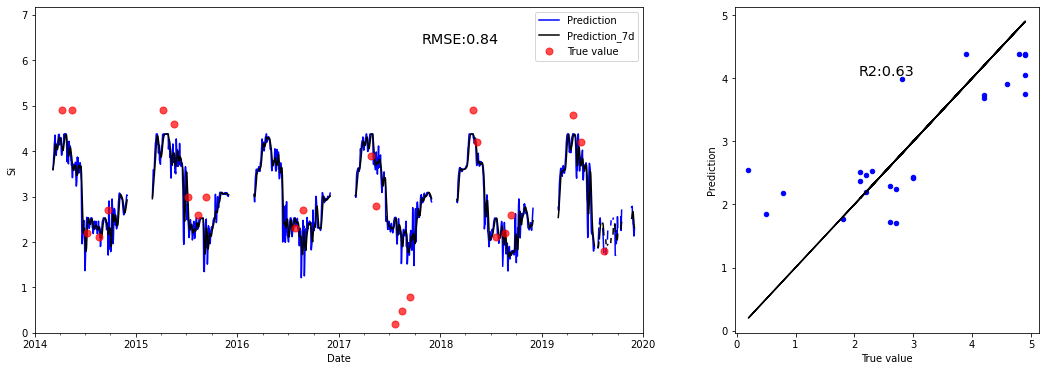

In [69]:
# predict nutreint 6
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

Scaler = MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [70]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX,O2,PO4-P,Tot-P,NH4-N,Si
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8693,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890,8.367984,34.064419,47.473713,4.776709,2.387539
8694,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305,8.339104,33.704712,47.480621,5.977872,2.296558
8695,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150,8.338394,33.564476,47.480827,5.317354,2.130368
8696,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428,8.376356,31.807388,47.442314,6.729635,2.139473


Nutrient: TOC
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 21) (4950,) (1093, 8, 21) (1093,)
number of input timesteps: 8
number of features: 21
number of samples: 99
Test RMSE: 0.86
Test R2: -0.42
Training dataset RMSE 0.71 (+/- 0.25)
Training dataset R2 0.08 (+/- 0.15)
Model takes 2 min to run


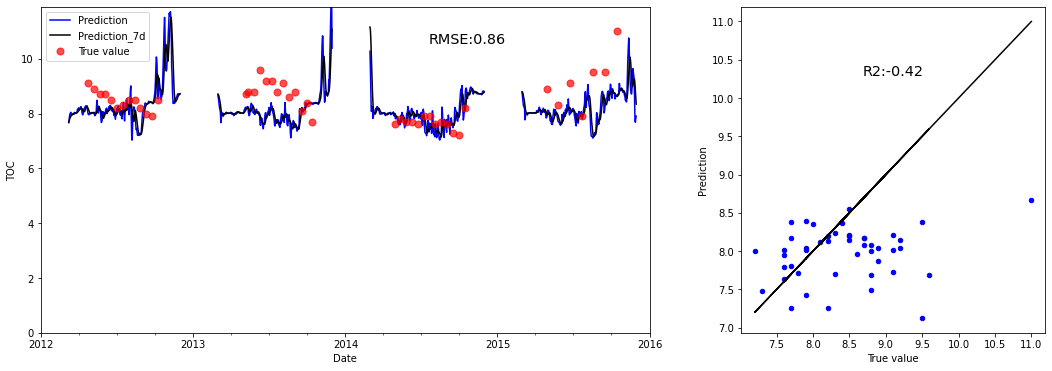

In [32]:
# predict nutreint 7
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
Scaler=MinMaxScaler()
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [33]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428


Nutrient: SiO2
['AirP', 'AirT', 'RelHum', 'SWR', 'CC', 'Prec', 'U', 'delT', 'inflow(m3/s)', 'outflow(m3/s)', 'Ice_d', 'days from iceoff', 'W', 'MLD', 'thermD', 'O2', 'NO3N', 'NH4N', 'PO4P', 'TOTP', 'TOTN', 'TOC']
Delete features? (Y/N)N
Add features? (Y/N)N
(4950, 8, 22) (4950,) (1093, 8, 22) (1093,)
number of input timesteps: 8
number of features: 22
number of samples: 167
Test RMSE: 1.15
Test R2: 0.43
Training dataset RMSE 0.83 (+/- 0.18)
Training dataset R2 0.51 (+/- 0.15)
Model takes 4 min to run


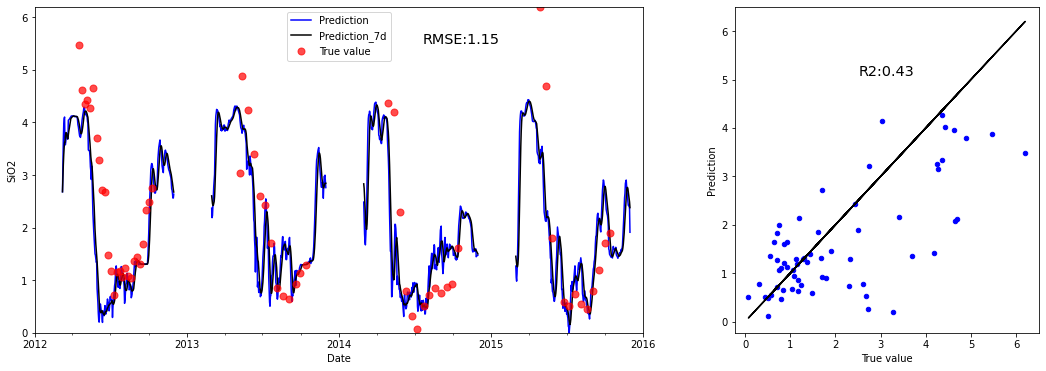

In [34]:
# predict nutreint 8
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 

features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [35]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,AirP,AirT,RelHum,SWR,CC,Prec,U,delT,inflow(m3/s),outflow(m3/s),Ice_d,days from iceoff,W,MLD,thermD,O2,NO3N,NH4N,PO4P,TOTP,TOTN,TOC,SiO2
0,1994-03-01,1018.4190,-9.955431,70.289411,55.50429,0.458692,0.830272,3.483176,0.256206,1.334310,0.618518,149,-54.0,2.724398,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
1,1994-03-02,1012.0800,-8.835930,81.223724,54.56624,0.854867,1.530000,3.226721,0.256183,1.319589,0.606296,149,-53.0,2.191399,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
2,1994-03-03,1002.8600,-4.911451,88.727730,107.72920,0.993754,0.423039,1.846146,0.256237,1.305278,0.594445,149,-52.0,4.483183,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
3,1994-03-04,1005.3750,-2.776745,91.194580,134.25160,0.708459,0.000784,0.842008,0.256201,1.289619,0.582592,149,-51.0,254.546565,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
4,1994-03-05,997.0792,2.236131,92.617668,80.39046,1.000008,0.338688,7.107113,0.256180,5.335259,2.310000,149,-50.0,0.000000,19.0000,19.0000,12.846180,753.809998,6.757834,7.802194,30.724924,1210.347046,8.288702,3.877831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6045,2015-11-26,994.5456,0.139770,93.686831,20.64251,0.548573,0.000000,2.173018,2.130598,13.161086,5.502222,81,258.0,20.616081,10.6501,10.6501,8.872602,55.972729,15.604255,8.623958,31.749716,784.934448,8.587276,2.421144
6046,2015-11-27,985.3168,9.021081,90.547242,21.62850,0.968004,0.001345,6.680271,1.606879,12.064328,4.874074,81,259.0,3.705116,11.0968,11.0968,8.792369,16.538393,19.361982,7.025309,29.891218,702.546997,7.742613,2.417079
6047,2015-11-28,978.9278,4.759586,86.624472,21.59980,0.634158,0.003703,4.535557,0.004524,21.783314,5.718518,81,260.0,0.032103,19.0000,19.0000,8.806619,158.694748,22.888605,6.790660,29.994944,729.221436,7.682547,2.430667
6048,2015-11-29,969.5997,3.935289,87.554448,20.77313,0.928686,0.000335,4.846388,0.003058,29.578538,7.736296,81,261.0,0.049188,19.0000,19.0000,8.846630,190.166748,22.555815,6.788723,28.392122,764.089233,7.832428,2.352034


Nutrient: Chl
['thermD', 'W', 'MLD', 'CC', 'U', 'Prec', 'Inflow', 'Ice_d', 'day_from_iceoff', 'delT', 'AirP', 'AirT', 'swr', 'RelHum', 'NOX', 'O2', 'PO4-P', 'Tot-P', 'NH4-N', 'Si']
Delete features? (Y/N)N
Add features? (Y/N)N
(7292, 8, 20) (7292,) (1555, 8, 20) (1555,)
number of input timesteps: 8
number of features: 20
number of samples: 477
Test RMSE: 15.82
Test R2: -0.28
Training dataset RMSE 6.32 (+/- 1.11)
Training dataset R2 0.33 (+/- 0.08)
Model takes 7 min to run


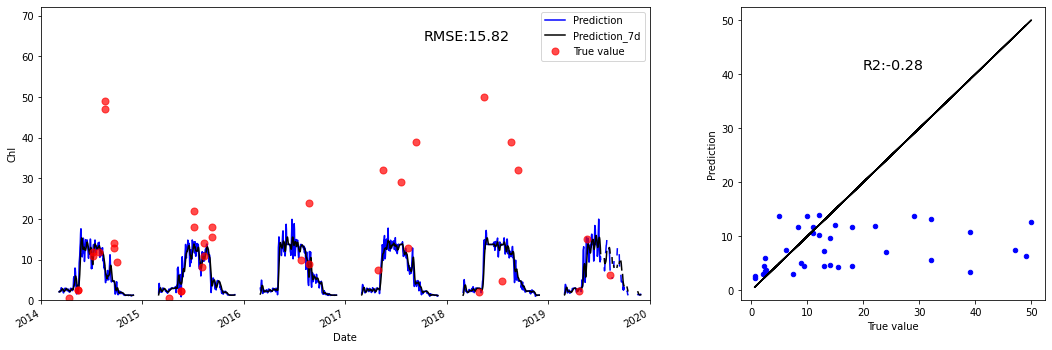

In [71]:
# predict Chl
nutrient = input('Nutrient: ')
print(features)
delet = input('Delete features? (Y/N)')
while delet=='Y':
    print(features)
    idx = int(input('Location of the feature:'))
    features.pop(idx)
    delet = input('Delete features? (Y/N)')
add = input('Add features? (Y/N)')
while add =='Y':
    f = input('New feature:')
    features.append(f)
    print(features)
    add = input('Add features? (Y/N)') 
    
Scaler = MinMaxScaler()#PowerTransformer(standardize=False)
features.append(nutrient)
Nut_memory = Nut_memory.merge(pd.concat([Nut['Date'],Nut[nutrient]],axis = 1).dropna().drop_duplicates(),
                              how = 'left',on = 'Date')
values = load_dataset(Nut_memory,features) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,features,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
figure.savefig(lakename+'_LSTM_'+nutrient+'.png',dpi = 500)

In [72]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory

c:\users\shuli278\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,thermD,W,MLD,CC,U,Prec,Inflow,Ice_d,day_from_iceoff,delT,AirP,AirT,swr,RelHum,NOX,O2,PO4-P,Tot-P,NH4-N,Si,Chl
0,1987-03-01,-7.9424,0.032502,-1.838322,0.009583,1.922666,0.0,8.83356,118,-52.0,-0.640693,1034.279167,-13.645833,391.22,76.250000,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576,2.240036
1,1987-03-02,-7.8574,0.032367,-1.957385,0.010000,2.314110,0.0,8.41115,118,-51.0,-0.628456,1027.775000,-14.970833,327.40,81.500000,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576,2.240036
2,1987-03-03,-7.7557,0.023858,-2.079543,0.010000,2.712480,0.0,8.00893,118,-50.0,-0.616420,1028.191667,-12.933333,332.54,77.666667,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576,2.240036
3,1987-03-04,-7.5988,0.020422,-2.204526,0.010000,2.189217,0.0,7.62595,118,-49.0,-0.604578,1023.516667,-13.508333,307.18,78.208333,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576,2.240036
4,1987-03-05,-7.4612,0.033894,-2.335355,0.009583,1.144692,0.0,7.26129,118,-48.0,-0.586730,1032.479167,-14.662500,414.74,70.791667,1321.653442,11.519440,28.403126,50.865154,10.586343,3.600576,2.240036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849,2019-11-26,-36.8000,0.079558,-36.800000,0.002917,2.053492,1.5,10.63090,65,246.0,-0.007590,1009.479167,3.900000,23.48,97.958333,883.561890,8.367984,34.064419,47.473713,4.776709,2.387539,1.312793
8850,2019-11-27,-36.8000,0.038681,-36.800000,0.000833,1.987508,10.8,20.63590,65,247.0,-0.007492,1000.137500,4.187500,20.90,100.000000,868.375305,8.339104,33.704712,47.480621,5.977872,2.296558,1.311311
8851,2019-11-28,-36.8000,0.084073,-36.800000,0.002083,2.761970,14.5,26.46790,65,248.0,-0.007811,988.583333,3.504167,18.75,99.791667,864.004150,8.338394,33.564476,47.480827,5.317354,2.130368,1.328908
8852,2019-11-29,-36.8000,0.031708,-36.800000,0.002500,3.315994,8.5,46.66420,65,249.0,-0.009311,993.241667,-2.604167,67.52,96.666667,887.763428,8.376356,31.807388,47.442314,6.729635,2.139473,1.487052


In [73]:
Nut_memory.to_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep='\t',index=False)